# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scipy.interpolate import interp1d
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
numerical = ['num_likes', 'num_comments', 'num_sent', 'sent_avg_length', 'num_words', 
             'num_unique_words', 'unique_words_percent', 'age', 'num_cats',
             'words_exist_per_cent',
             'shortlisted',
             'emotion_anger', 'emotion_fear', 'emotion_joy', 'emotion_love', 
             'emotion_sadness', 'emotion_surprise', 
             'sentiment_POSITIVE_no_prepro', 'sentiment_NEGATIVE_no_prepro', 
             'sentiment_hf_text']

txt_features = ['text_str', 'text_str_lem']

categories = [   'cat_Age', 'cat_Happy', 'cat_Thriller', 
                 'cat_Friendship', 'cat_East', 'cat_Inspirational', 
                 'cat_Christian', 'cat_Bedtime', 'cat_Drama', 'cat_Horror', 
                 'cat_Lesbian', 'cat_High', 'cat_Science', 'cat_American', 
                 'cat_Speculative', 'cat_Funny', 'cat_Adventure', 
                 'cat_Nonfiction', 'cat_African', 'cat_Christmas', 
                 'cat_Teens', 'cat_Fantasy', 'cat_Holiday', 'cat_Western', 
                 'cat_Young', 'cat_Coming', 'cat_Suspense', 'cat_Romance', 
                 'cat_Urban', 'cat_Latinx', 'cat_Desi', 'cat_Asian', 
                 'cat_Black', 'cat_Sad', 'cat_Kids', 'cat_People', 'cat_Color', 
                 'cat_Fiction', 'cat_Contemporary', 'cat_Mystery', 'cat_Adult', 
                 'cat_Transgender', 'cat_Historical', 'cat_Middle', 'cat_Gay', 
                 'cat_Indigenous', 'cat_Crime', 'num_cats', 'cat_School', 
                 'cat_Creative']

In [3]:
feats_to_keep = numerical + txt_features + categories

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# df = pd.read_csv("drive/MyDrive/Final Project/story_data_new_feats.csv", 
#                  usecols=feats_to_keep)
df = pd.read_csv("story_data_new_feats.csv", 
                 usecols=feats_to_keep)

In [6]:
target = 'num_likes'

# General features

## Preprocessing

In [7]:
numerical.remove('num_likes')
numerical.remove('num_comments')
numerical.remove('shortlisted')

In [8]:
X_gen = df[numerical+categories]

In [9]:
y = df[target].copy()

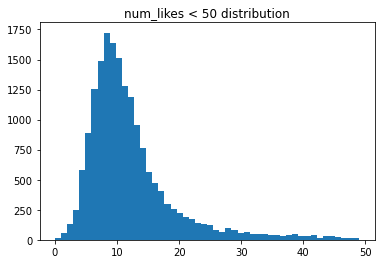

In [10]:
# TODO: to add this graph in the Medium article
df[df[target]<50][target].hist(bins=50, grid=False)
plt.title('num_likes < 50 distribution')
plt.show()

In [11]:
# turn y into labels 0 and 1, given a threshold
threshold = np.quantile(y, 0.7)
threshold

13.0

In [12]:
print(f'Our threshold corresponds to \n{100*len(y[y <= threshold])/len(y):.2f}% of the stories being "bad", \n{100*len(y[y > threshold])/len(y):.2f}% of the stories being "good".')

Our threshold corresponds to 
71.03% of the stories being "bad", 
28.97% of the stories being "good".


In [13]:
from sklearn.preprocessing import Binarizer

bn = Binarizer(threshold=threshold).fit(df[[target]])
y = bn.transform(df[[target]])

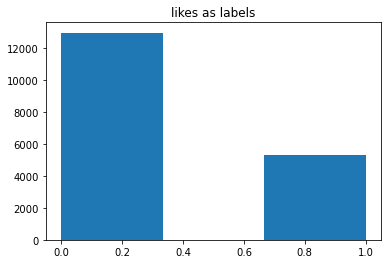

In [14]:
plt.hist(y, bins=3)
plt.title('likes as labels');

In [15]:
# log transform for relevant distributions
for var_to_log in ['sent_avg_length', 'num_unique_words', 'emotion_love']:
    X_gen.loc[:, var_to_log] = X_gen.loc[:, var_to_log].apply(np.log1p)

C:\Users\Batra\AppData\Local\Temp/ipykernel_17956/3685043624.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_gen.loc[:, var_to_log] = X_gen.loc[:, var_to_log].apply(np.log1p)


In [16]:
X_gen[['sent_avg_length', 'num_unique_words', 'emotion_love']].describe()

,sent_avg_length,num_unique_words,emotion_love
count,18248.000000,18248.000000,18248.000000
mean,2.945298,6.441081,0.026113
std,0.297524,0.289961,0.024489
min,1.648124,5.236442,0.000000
25%,2.764136,6.204558,0.009009
50%,2.920225,6.410175,0.020409
75%,3.089229,6.677083,0.037434
max,7.286192,7.318540,0.274437


In [17]:
from sklearn.model_selection import train_test_split

test_size = 20/100

X_train_gen, X_test_gen, y_train, y_test = train_test_split(X_gen, y, 
                                                    test_size=test_size, 
                                                    random_state=42, 
                                                   stratify=y)
X_train_gen.shape, X_test_gen.shape, y_train.shape, y_test.shape

((14598, 67), (3650, 67), (14598, 1), (3650, 1))

In [18]:
# feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_gen = pd.DataFrame(scaler.fit_transform(X_train_gen), columns=X_train_gen.columns)
X_test_gen = pd.DataFrame(scaler.transform(X_test_gen), columns=X_train_gen.columns)

X_train_gen.shape, X_test_gen.shape

((14598, 67), (3650, 67))

In [19]:
train_ind = X_train_gen.index
test_ind = X_test_gen.index

In [20]:
y_train = y_train.ravel()
y_test = y_test.ravel()

## Predictions

### Help functions

In [21]:
def display_conf_matr(y_test, y_pred, model, threshold=0.5):
    conf_matr = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(3, 3))
    sns.heatmap(conf_matr, cmap=['white'], annot=True, fmt='d', cbar=False, 
            linecolor='k', linewidth=2)
    plt.xlabel('predicted')
    plt.ylabel('true')
    plt.title(f'confusion matrix for {model}\nwhen threshold={threshold:.4f}')
    plt.show()
    print('\n')
    
    # extra metrics
    tn, fp, fn, tp = conf_matr.ravel()

    print(f'{tp*100/(tp+fn):.2f}% of the good stories have been correctly identified ~ recall')
    print(f'{fp*100/(fp+tn):.2f}% of the bad stories have been incorrectly identified as good ones ~ TNR')

In [22]:
def display_roc_curve(y_test,  y_probs, name_model):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
    auc = roc_auc_score(y_test, y_probs)

    plt.plot(fpr, tpr, label=f'{name_model}, AUC={auc:.4f}')
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="no model. AUC=.5")
    plt.title(f"Receiver operating characteristic\nROC curve - {name_model}")
    plt.xlabel('rate of false positives\nFPR')
    plt.ylabel('rate of true positives\nTPR')
    plt.legend(loc='best')
    plt.show()

In [23]:
def display_feat_importance(coefs, cols):
    try:
        cols = [x for _, x in sorted(zip(coefs, cols))]
        plt.figure(figsize=(15,15))
        for col, coef in zip(cols, sorted(coefs)):
            plt.barh(col, coef)
    except AttributeError:
        print('No feature importance')
    plt.show()

In [24]:
def display_model_results(model, X_train, X_test, y_train, y_test, name_model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # classification report
    print('Classification report\nfor default threshold')
    print(classification_report(y_test, y_pred))
    print('\n')

    # confusion matrix
    display_conf_matr(y_test, y_pred, name_model)
    print('\n')

    # roc curve
    y_probs = model.predict_proba(X_test)[:,1]
    display_roc_curve(y_test,  y_probs, name_model)
    print('\n')

    # feature importance
#     display_feat_importance(model.coef_.tolist()[0], X_train.columns)

    return model


In [25]:
def play_with_threshold(recall_value, y_test, y_probs, model_name):
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

    x = np.linspace(0,1, num=len(precision))
    y = interp1d(recall, precision)
    precision_value = y(recall_value)
    
    plt.plot(recall, precision, c='g', label=model_name)
    
    plt.plot(x, [precision_value]*len(recall), label=f'precision={precision_value:.2f}')
    plt.axvline(recall_value, label=f'recall={recall_value:.2f}')
    
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title(f"precision-recall curve\nfor {model_name}")
    plt.legend()
    plt.show()

    if len(thresholds)<len(recall):
        thresholds = np.append(thresholds,0)
    y_thresholds = interp1d(recall, thresholds)
    threshold_value = y_thresholds(recall_value)
    print('\n')
    print(f'When recall is equal to {recall_value:.2f}, precision is equal to {precision_value:.2f}, and the threshold is equal to {threshold_value:.2f}.')
    y_pred = np.where(y_probs >= threshold_value, 1, 0)
    # classification report
    print(f'Classification report\nfor threshold={threshold_value:.4f}')
    print(classification_report(y_test, y_pred))
    print('\n')
    
    return threshold_value

### Logistic regression

Classification report
for default threshold
              precision    recall  f1-score   support

           0       0.71      0.98      0.83      2592
           1       0.47      0.04      0.07      1058

    accuracy                           0.71      3650
   macro avg       0.59      0.51      0.45      3650
weighted avg       0.64      0.71      0.61      3650





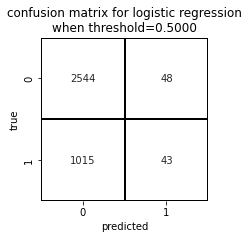



4.06% of the good stories have been correctly identified ~ recall
1.85% of the bad stories have been incorrectly identified as good ones ~ TNR




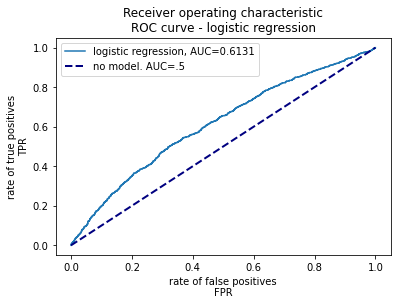

In [26]:
clf_log_gen = display_model_results(LogisticRegression(random_state=0), 
                      X_train_gen, X_test_gen, y_train, y_test, 
                      'logistic regression')

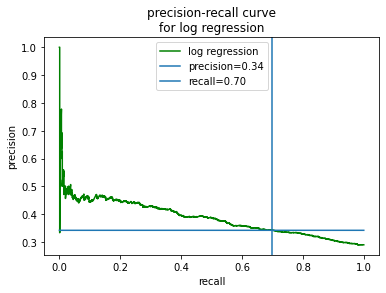



When recall is equal to 0.70, precision is equal to 0.34, and the threshold is equal to 0.26.
Classification report
for threshold=0.2565
              precision    recall  f1-score   support

           0       0.79      0.45      0.57      2592
           1       0.34      0.70      0.46      1058

    accuracy                           0.52      3650
   macro avg       0.56      0.58      0.52      3650
weighted avg       0.66      0.52      0.54      3650





In [27]:
recall_value = 0.7 # chose wanted recall value
log_probs_gen = clf_log_gen.predict_proba(X_test_gen)[:,1]
p_threshold = play_with_threshold(recall_value, y_test, log_probs_gen, 'log regression')

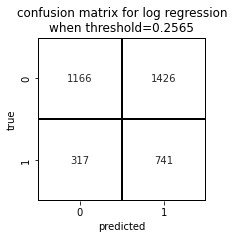



70.04% of the good stories have been correctly identified ~ recall
55.02% of the bad stories have been incorrectly identified as good ones ~ TNR


In [28]:
log_pred_gen = np.where(log_probs_gen >= p_threshold, 1, 0)
display_conf_matr(y_test, log_pred_gen, 'log regression', p_threshold)

### SVM

In [29]:
# clf_svm = display_model_results(SVC(probability=True, random_state=0), 
#                       X_train_gen, X_test_gen, y_train, y_test, 
#                       'SVM')

In [30]:
# recall_value = 0.7 # chose wanted recall value
# p_threshold = play_with_threshold(recall_value, X_test_gen, y_test, clf_svm, 'svm')

In [31]:
# conf_matrix(clf_log, p_threshold, X_test_gen, y_test)

### KNN 

k that minimizes the validation set error: 18


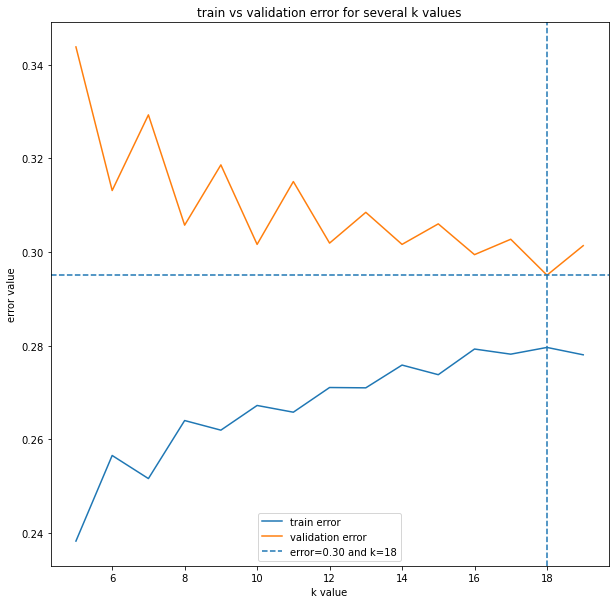

In [32]:
errors_train = []
errors_val = []
k_values = list(range(5, 20))

for k in k_values:
  neigh = KNeighborsClassifier(k)
  neigh.fit(X_train_gen, y_train)
  error_train = 1 - neigh.score(X_train_gen, y_train) 
  error_val   = 1 - neigh.score(X_test_gen, y_test) 
  errors_train.append(error_train)
  errors_val.append(error_val)

k_best = k_values[errors_val.index(min(errors_val))]
plt.figure(figsize=(10,10))
plt.plot(k_values, errors_train, label='train error')
plt.plot(k_values, errors_val, label='validation error')
plt.axhline(y = min(errors_val), linestyle = '--', label=f'error={min(errors_val):.2f} and k={k_best}')
plt.axvline(x=k_best, linestyle = '--')
plt.xlabel('k value')
plt.ylabel('error value')
plt.title('train vs validation error for several k values')
plt.legend()

print(f'k that minimizes the validation set error: {k_best}')

Classification report
for default threshold
              precision    recall  f1-score   support

           0       0.71      0.97      0.82      2592
           1       0.42      0.05      0.09      1058

    accuracy                           0.70      3650
   macro avg       0.57      0.51      0.46      3650
weighted avg       0.63      0.70      0.61      3650





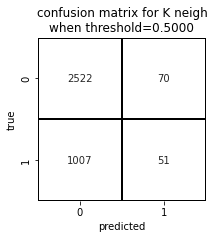



4.82% of the good stories have been correctly identified ~ recall
2.70% of the bad stories have been incorrectly identified as good ones ~ TNR




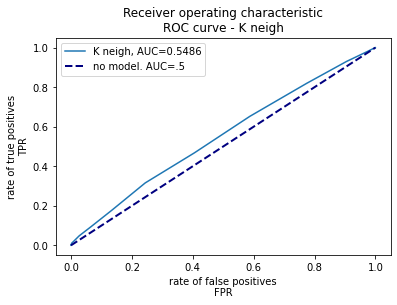

In [33]:
clf_neigh_gen = display_model_results(KNeighborsClassifier(n_neighbors=k_best), 
                      X_train_gen, X_test_gen, y_train, y_test, 
                      'K neigh')

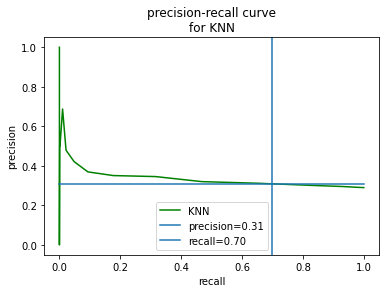



When recall is equal to 0.70, precision is equal to 0.31, and the threshold is equal to 0.26.
Classification report
for threshold=0.2619
              precision    recall  f1-score   support

           0       0.74      0.41      0.53      2592
           1       0.31      0.65      0.42      1058

    accuracy                           0.48      3650
   macro avg       0.53      0.53      0.48      3650
weighted avg       0.62      0.48      0.50      3650





In [34]:
recall_value = 0.7 # chose wanted recall value
knn_probs_gen = clf_neigh_gen.predict_proba(X_test_gen)[:,1]
p_threshold = play_with_threshold(recall_value, y_test, knn_probs_gen, 'KNN')

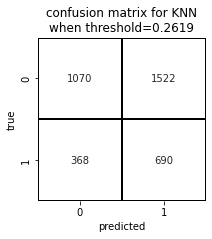



65.22% of the good stories have been correctly identified ~ recall
58.72% of the bad stories have been incorrectly identified as good ones ~ TNR


In [35]:
knn_pred_gen = np.where(knn_probs_gen >= p_threshold, 1, 0)
display_conf_matr(y_test, knn_pred_gen, 'KNN', p_threshold)

### Random forest

Classification report
for default threshold
              precision    recall  f1-score   support

           0       0.71      0.99      0.83      2592
           1       0.56      0.02      0.04      1058

    accuracy                           0.71      3650
   macro avg       0.64      0.51      0.44      3650
weighted avg       0.67      0.71      0.60      3650





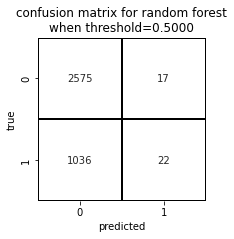



2.08% of the good stories have been correctly identified ~ recall
0.66% of the bad stories have been incorrectly identified as good ones ~ TNR




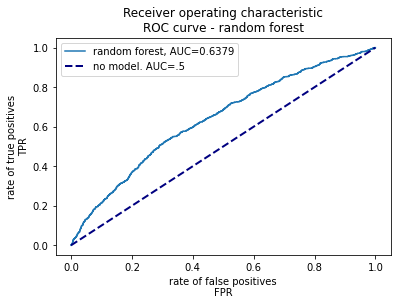

In [36]:
clf_rf_gen = display_model_results(RandomForestClassifier(max_depth=10, random_state=0), 
                      X_train_gen, X_test_gen, y_train, y_test, 
                      'random forest')

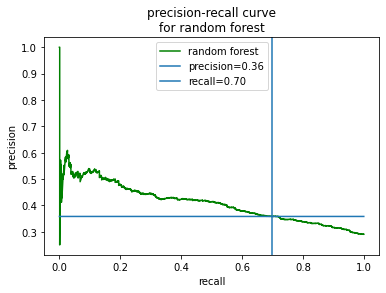



When recall is equal to 0.70, precision is equal to 0.36, and the threshold is equal to 0.26.
Classification report
for threshold=0.2590
              precision    recall  f1-score   support

           0       0.80      0.49      0.61      2592
           1       0.36      0.70      0.47      1058

    accuracy                           0.55      3650
   macro avg       0.58      0.59      0.54      3650
weighted avg       0.67      0.55      0.57      3650





In [37]:
recall_value = 0.7 # chose wanted recall value
rf_probs_gen = clf_rf_gen.predict_proba(X_test_gen)[:,1]
p_threshold = play_with_threshold(recall_value, y_test, rf_probs_gen, 'random forest')

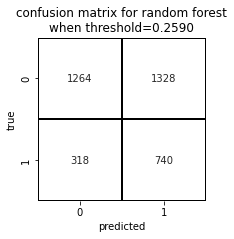



69.94% of the good stories have been correctly identified ~ recall
51.23% of the bad stories have been incorrectly identified as good ones ~ TNR


In [38]:
rf_pred_gen = np.where(rf_probs_gen >= p_threshold, 1, 0)
display_conf_matr(y_test, rf_pred_gen, 'random forest', p_threshold)

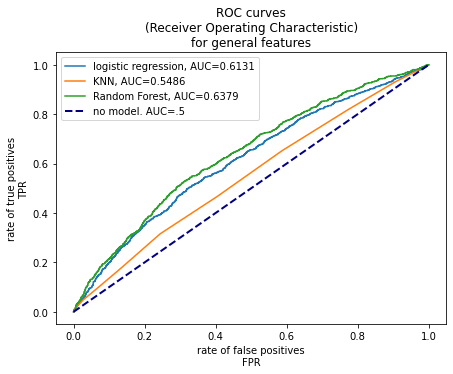

In [40]:
models = ['logistic regression', 'KNN', 'Random Forest']
probs = [log_probs_gen, knn_probs_gen, rf_probs_gen]

plt.figure(figsize=(7, 5))
for i, model in enumerate(models):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[i])
    auc = roc_auc_score(y_test, probs[i])

    plt.plot(fpr, tpr, label=f'{model}, AUC={auc:.4f}')
    
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="no model. AUC=.5")
# plt.set(title=(f"Receiver operating characteristic\nROC curve - {name_model}"), 
#        xlabel=('rate of false positives\nFPR'), ylabel=('rate of true positives\nTPR'))
plt.title('ROC curves\n(Receiver Operating Characteristic)\nfor general features')
plt.xlabel('rate of false positives\nFPR')
plt.ylabel('rate of true positives\nTPR')
plt.legend(loc='best')
plt.show()

# TF/IDF only

## Preprocessing

In [41]:
lemmas = df['text_str_lem']

In [42]:
lemmas_train = lemmas.iloc[train_ind].tolist()
lemmas_test = lemmas.iloc[test_ind].tolist()
len(lemmas_train), len(lemmas_test)

(14598, 3650)

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

max_features = 10000
vectorizer = TfidfVectorizer(ngram_range=(1,3), 
                             max_features=max_features,
                             stop_words={'english'},
                             norm='l2')

vectorizer.fit(lemmas_train)

TfidfVectorizer(max_features=10000, ngram_range=(1, 3), stop_words={'english'})

In [44]:
X_train_tfidf = pd.DataFrame(vectorizer.transform(lemmas_train).toarray())
X_test_tfidf = pd.DataFrame(vectorizer.transform(lemmas_test).toarray())

X_train_tfidf.shape, X_test_tfidf.shape, y_train.shape, y_test.shape

((14598, 10000), (3650, 10000), (14598,), (3650,))

## Predictions

### Log regression

Classification report
for default threshold
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      2592
           1       0.00      0.00      0.00      1058

    accuracy                           0.71      3650
   macro avg       0.36      0.50      0.42      3650
weighted avg       0.50      0.71      0.59      3650





C:\Users\Batra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


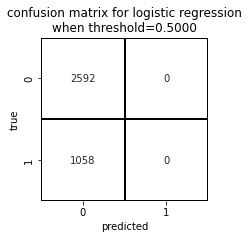



0.00% of the good stories have been correctly identified ~ recall
0.00% of the bad stories have been incorrectly identified as good ones ~ TNR




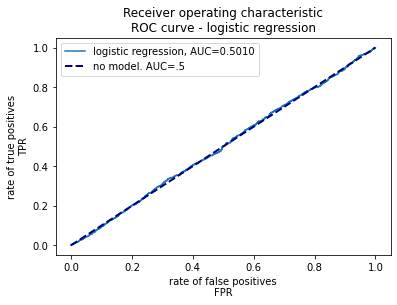

In [45]:
clf_log_tfidf = display_model_results(LogisticRegression(random_state=0), 
                      X_train_tfidf, X_test_tfidf, y_train, y_test, 
                      'logistic regression')

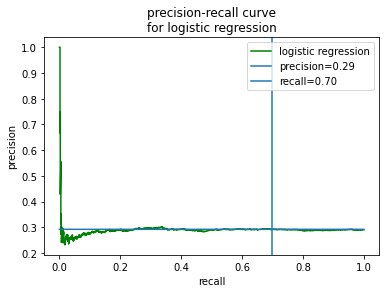



When recall is equal to 0.70, precision is equal to 0.29, and the threshold is equal to 0.27.
Classification report
for threshold=0.2694
              precision    recall  f1-score   support

           0       0.72      0.31      0.43      2592
           1       0.29      0.70      0.41      1058

    accuracy                           0.42      3650
   macro avg       0.50      0.50      0.42      3650
weighted avg       0.59      0.42      0.43      3650





In [46]:
recall_value = 0.7 # chose wanted recall value
log_probs_tfidf = clf_log_tfidf.predict_proba(X_test_tfidf)[:,1]
p_threshold = play_with_threshold(recall_value, y_test, log_probs_tfidf, 'logistic regression')

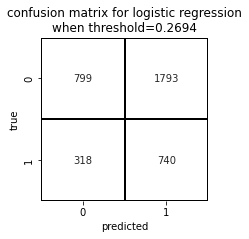



69.94% of the good stories have been correctly identified ~ recall
69.17% of the bad stories have been incorrectly identified as good ones ~ TNR


In [47]:
log_pred_tfidf = np.where(log_probs_tfidf >= p_threshold, 1, 0)
display_conf_matr(y_test, log_pred_tfidf, 'logistic regression', p_threshold)

### SVM

In [48]:
# takes too much time
# clf_svm = display_model_results(SVC(probability=False, ), 
#                       X_train, X_test, y_train, y_test, 
#                       'SVM')

In [49]:
# recall_value = 0.5 # chose wanted recall value
# play_with_threshold(recall_value, y_test, clf_svm, 'svm')

### KNN

Classification report
for default threshold
              precision    recall  f1-score   support

           0       0.71      0.98      0.82      2592
           1       0.20      0.01      0.02      1058

    accuracy                           0.70      3650
   macro avg       0.45      0.50      0.42      3650
weighted avg       0.56      0.70      0.59      3650





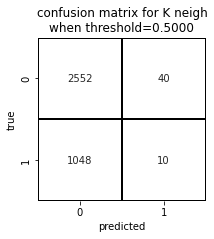



0.95% of the good stories have been correctly identified ~ recall
1.54% of the bad stories have been incorrectly identified as good ones ~ TNR




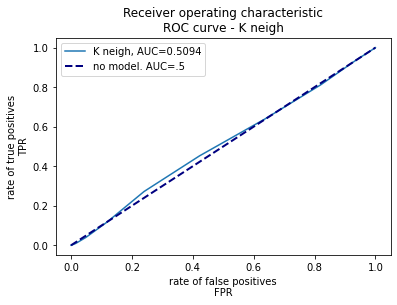

In [50]:
clf_neigh_tfidf = display_model_results(KNeighborsClassifier(n_neighbors=k_best), 
                      X_train_tfidf, X_test_tfidf, y_train, y_test, 
                      'K neigh')

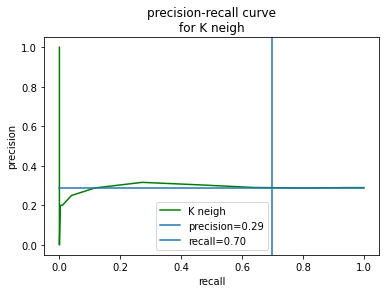



When recall is equal to 0.70, precision is equal to 0.29, and the threshold is equal to 0.26.
Classification report
for threshold=0.2579
              precision    recall  f1-score   support

           0       0.71      0.36      0.48      2592
           1       0.29      0.64      0.40      1058

    accuracy                           0.44      3650
   macro avg       0.50      0.50      0.44      3650
weighted avg       0.59      0.44      0.46      3650





In [51]:
recall_value = 0.7 # chose wanted recall value
knn_probs_tfidf = clf_neigh_tfidf.predict_proba(X_test_tfidf)[:,1]
p_threshold = play_with_threshold(recall_value, y_test, knn_probs_tfidf, 'K neigh')

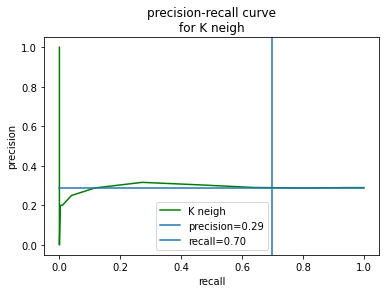



When recall is equal to 0.70, precision is equal to 0.29, and the threshold is equal to 0.26.
Classification report
for threshold=0.2579
              precision    recall  f1-score   support

           0       0.71      0.36      0.48      2592
           1       0.29      0.64      0.40      1058

    accuracy                           0.44      3650
   macro avg       0.50      0.50      0.44      3650
weighted avg       0.59      0.44      0.46      3650





array(0.25786278)

In [52]:
play_with_threshold(recall_value, y_test, knn_probs_tfidf, 'K neigh')

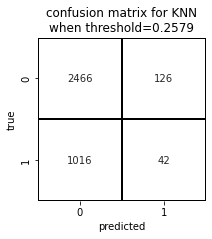



3.97% of the good stories have been correctly identified ~ recall
4.86% of the bad stories have been incorrectly identified as good ones ~ TNR


In [53]:
knn_pred_tfidf = np.where(knn_probs_tfidf >= 0.5, 1, 0)
display_conf_matr(y_test, knn_pred_tfidf, 'KNN', p_threshold)

### Random forest

Classification report
for default threshold
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      2592
           1       0.00      0.00      0.00      1058

    accuracy                           0.71      3650
   macro avg       0.36      0.50      0.42      3650
weighted avg       0.50      0.71      0.59      3650





C:\Users\Batra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


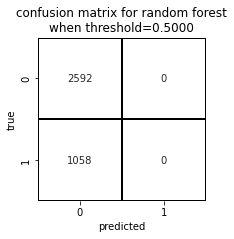



0.00% of the good stories have been correctly identified ~ recall
0.00% of the bad stories have been incorrectly identified as good ones ~ TNR




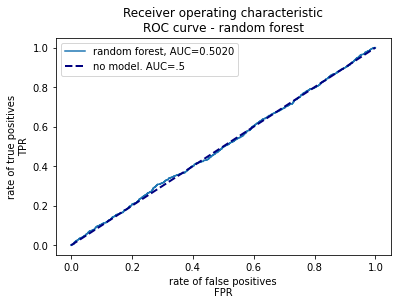

In [54]:
clf_rf_tfidf = display_model_results(RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=0), 
                      X_train_tfidf, X_test_tfidf, y_train, y_test, 
                      'random forest')

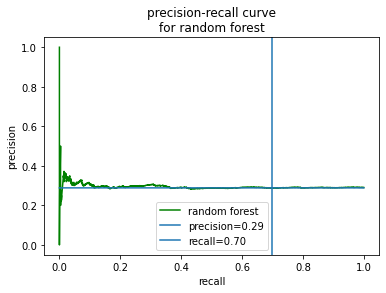



When recall is equal to 0.70, precision is equal to 0.29, and the threshold is equal to 0.28.
Classification report
for threshold=0.2843
              precision    recall  f1-score   support

           0       0.71      0.30      0.42      2592
           1       0.29      0.70      0.41      1058

    accuracy                           0.41      3650
   macro avg       0.50      0.50      0.41      3650
weighted avg       0.59      0.41      0.41      3650





In [55]:
recall_value = 0.7 # chose wanted recall value
rf_probs_tfidf = clf_rf_tfidf.predict_proba(X_test_tfidf)[:,1]
p_threshold = play_with_threshold(recall_value, y_test, rf_probs_tfidf, 'random forest')

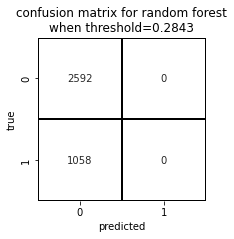



0.00% of the good stories have been correctly identified ~ recall
0.00% of the bad stories have been incorrectly identified as good ones ~ TNR


In [56]:
rf_pred_tfidf = np.where(rf_probs_tfidf >= 0.5, 1, 0)
display_conf_matr(y_test, rf_pred_tfidf, 'random forest', p_threshold)

In [57]:
# recall_value = 0.7 # chose wanted recall value
# log_probs_tfidf = clf_log_tfidf.predict_proba(X_test_tfidf)[:,1]
# p_threshold = play_with_threshold(recall_value, y_test, log_probs_tfidf, 'logistic regression')

# log_pred_tfidf = np.where(log_probs_tfidf >= 0.5, 1, 0)
# display_conf_matr(y_test, log_pred_tfidf, 'logistic regression', p_threshold)

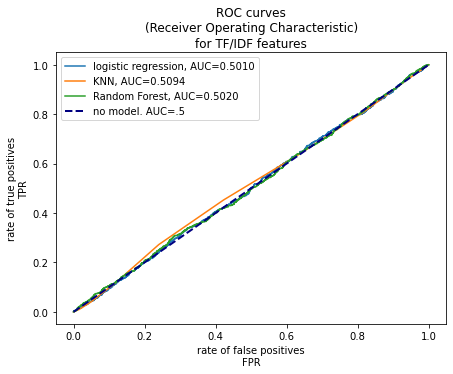

In [58]:
models = ['logistic regression', 'KNN', 'Random Forest']
probs = [log_probs_tfidf, knn_probs_tfidf, rf_probs_tfidf]

plt.figure(figsize=(7, 5))
for i, model in enumerate(models):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[i])
    auc = roc_auc_score(y_test, probs[i])

    plt.plot(fpr, tpr, label=f'{model}, AUC={auc:.4f}')
    
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="no model. AUC=.5")
# plt.set(title=(f"Receiver operating characteristic\nROC curve - {name_model}"), 
#        xlabel=('rate of false positives\nFPR'), ylabel=('rate of true positives\nTPR'))
plt.title('ROC curves\n(Receiver Operating Characteristic)\nfor TF/IDF features')
plt.xlabel('rate of false positives\nFPR')
plt.ylabel('rate of true positives\nTPR')
plt.legend(loc='best')
plt.show()

### Adaboost

In [59]:
from sklearn.ensemble import AdaBoostClassifier

In [60]:
clf_ada_tfidf = display_model_results(AdaBoostClassifier(n_estimators=100, random_state=0), 
                      X_train_tfidf, X_test_tfidf, y_train, y_test, 
                      'AdaBoostClassifier')

KeyboardInterrupt: 

In [ ]:
recall_value = 0.7 # chose wanted recall value
ada_probs_tfidf = clf_ada_tfidf.predict_proba(X_test_tfidf)[:,1]
p_threshold = play_with_threshold(recall_value, y_test, ada_probs_tfidf, 'AdaBoostClassifier')

In [ ]:
ada_pred_tfidf = np.where(ada_probs_tfidf >= p_threshold, 1, 0)
display_conf_matr(y_test, ada_pred_tfidf, 'AdaBoostClassifier', p_threshold)

### GradientBoostingClassifier

In [61]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
clf_gbc_tfidf = display_model_results(GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0), 
                      X_train_tfidf, X_test_tfidf, y_train, y_test, 
                      'GradientBoostingClassifier')

In [ ]:
recall_value = 0.7 # chose wanted recall value
gbc_probs_tfidf = clf_gbc_tfidf.predict_proba(X_test_tfidf)[:,1]
p_threshold = play_with_threshold(recall_value, y_test, gbc_probs_tfidf, 'GradientBoostingClassifier')

In [ ]:
gbc_pred_tfidf = np.where(gbc_probs_tfidf >= p_threshold, 1, 0)
display_conf_matr(y_test, gbc_pred_tfidf, 'GradientBoostingClassifier', p_threshold)

### HistGradientBoostingClassifier

In [62]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [ ]:
clf_hist_tfidf = display_model_results(HistGradientBoostingClassifier(max_iter=100), 
                      X_train_tfidf, X_test_tfidf, y_train, y_test, 
                      'HistGradientBoostingClassifier')

In [ ]:
recall_value = 0.7 # chose wanted recall value
hist_probs_tfidf = clf_hist_tfidf.predict_proba(X_test_tfidf)[:,1]
p_threshold = play_with_threshold(recall_value, y_test, hist_probs_tfidf, 'HistGradientBoostingClassifier')

In [ ]:
hist_pred_tfidf = np.where(hist_probs_tfidf >= p_threshold, 1, 0)
display_conf_matr(y_test, hist_pred_tfidf, 'HistGradientBoostingClassifier', p_threshold)

### Soft vote

In [63]:
from sklearn.ensemble import VotingClassifier

In [ ]:
from sklearn.ensemble import VotingClassifier

eclf_tfidf = VotingClassifier(estimators=[('log', clf_log_tfidf), 
                                    ('neigh', clf_neigh_tfidf), 
                                    ('rf', clf_rf_tfidf), 
                                    ('ada', clf_ada_tfidf), 
                                    ('gbc', clf_gbc_tfidf)], 
                        voting='soft')

In [ ]:
eclf_tfidf = display_model_results(eclf_tfidf, 
                      X_train_tfidf, X_test_tfidf, y_train, y_test, 
                      'VotingClassifier')

In [ ]:
recall_value = 0.7 # chose wanted recall value
eclf_probs_tfidf = eclf_tfidf.predict_proba(X_test_tfidf)[:,1]
p_threshold = play_with_threshold(recall_value, y_test, eclf_probs_tfidf, 'VotingClassifier')

In [ ]:
eclf_pred_tfidf = np.where(eclf_probs_tfidf >= p_threshold, 1, 0)
display_conf_matr(y_test, eclf_pred_tfidf, 'VotingClassifier', p_threshold)

one graph with all of our ROC curves

In [ ]:
models = ['logistic regression', 'KNN', 'Random Forest', 'AdaBoost', 'GradientBoost', 'HistGradientBoost', 'Voting Classifier']
probs = [log_probs_tfidf, knn_probs_tfidf, rf_probs_tfidf, ada_probs_tfidf, gbc_probs_tfidf, hist_probs_tfidf, eclf_probs_tfidf]

plt.figure(figsize=(7, 5))
for i, model in enumerate(models):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[i])
    auc = roc_auc_score(y_test, probs[i])

    plt.plot(fpr, tpr, label=f'{model}, AUC={auc:.4f}')
    
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="no model. AUC=.5")
plt.title('ROC curves\n(Receiver Operating Characteristic)\nfor TF/IDF features')
plt.xlabel('rate of false positives\nFPR')
plt.ylabel('rate of true positives\nTPR')
plt.legend(loc='best')
plt.show()

# TF/IDF and general features (ensembling)

In [64]:
X_train_all = pd.concat([X_train_gen, X_train_tfidf], axis=1)
X_test_all = pd.concat([X_test_gen, X_test_tfidf], axis=1)

X_train_gen.shape, X_train_tfidf.shape, X_train_all.shape, X_test_gen.shape, X_test_tfidf.shape, X_test_all.shape

((14598, 67),
 (14598, 10000),
 (14598, 10067),
 (3650, 67),
 (3650, 10000),
 (3650, 10067))

## Predictions

### Log regression

C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Classification report
for default threshold
              precision    recall  f1-score   support

           0       0.72      0.97      0.82      2592
           1       0.45      0.06      0.11      1058

    accuracy                           0.71      3650
   macro avg       0.59      0.52      0.47      3650
weighted avg       0.64      0.71      0.62      3650





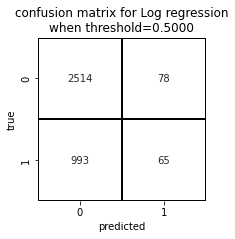



6.14% of the good stories have been correctly identified ~ recall
3.01% of the bad stories have been incorrectly identified as good ones ~ TNR




C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


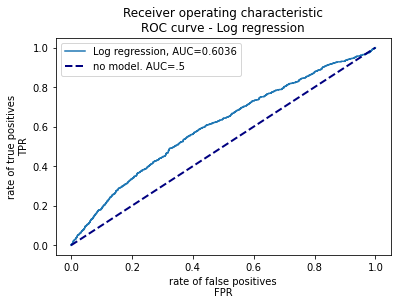

In [65]:
clf_log = display_model_results(LogisticRegression(), 
                      X_train_all, X_test_all, y_train, y_test, 
                      'Log regression')

C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


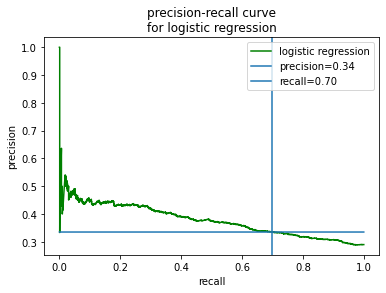



When recall is equal to 0.70, precision is equal to 0.34, and the threshold is equal to 0.25.
Classification report
for threshold=0.2506
              precision    recall  f1-score   support

           0       0.78      0.43      0.56      2592
           1       0.34      0.70      0.45      1058

    accuracy                           0.51      3650
   macro avg       0.56      0.57      0.51      3650
weighted avg       0.65      0.51      0.53      3650





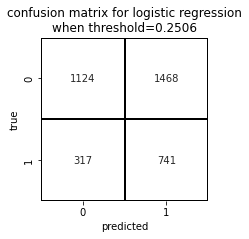



70.04% of the good stories have been correctly identified ~ recall
56.64% of the bad stories have been incorrectly identified as good ones ~ TNR


In [66]:
recall_value = 0.7 # chose wanted recall value
log_probs = clf_log.predict_proba(X_test_all)[:,1]
p_threshold = play_with_threshold(recall_value, y_test, log_probs, 'logistic regression')

log_pred = np.where(log_probs >= p_threshold, 1, 0)
display_conf_matr(y_test, log_pred, 'logistic regression', p_threshold)

### KNN

C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Classification report
for default threshold
              precision    recall  f1-score   support

           0       0.71      0.97      0.82      2592
           1       0.39      0.05      0.08      1058

    accuracy                           0.70      3650
   macro avg       0.55      0.51      0.45      3650
weighted avg       0.62      0.70      0.61      3650





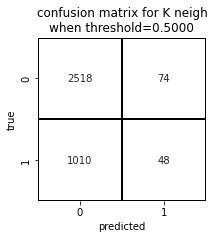



4.54% of the good stories have been correctly identified ~ recall
2.85% of the bad stories have been incorrectly identified as good ones ~ TNR




C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


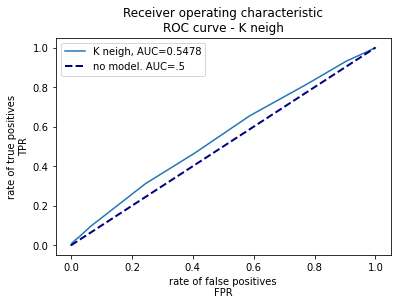

In [67]:
clf_neigh = display_model_results(KNeighborsClassifier(n_neighbors=k_best), 
                      X_train_all, X_test_all, y_train, y_test, 
                      'K neigh')

C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


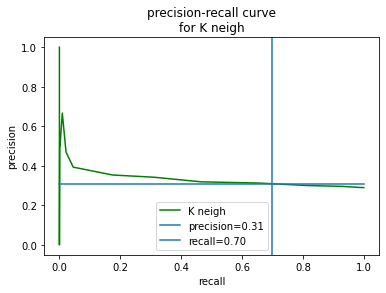



When recall is equal to 0.70, precision is equal to 0.31, and the threshold is equal to 0.26.
Classification report
for threshold=0.2625
              precision    recall  f1-score   support

           0       0.75      0.41      0.53      2592
           1       0.31      0.66      0.42      1058

    accuracy                           0.48      3650
   macro avg       0.53      0.53      0.48      3650
weighted avg       0.62      0.48      0.50      3650





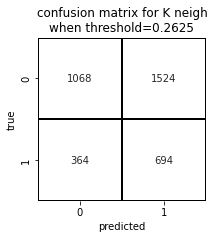



65.60% of the good stories have been correctly identified ~ recall
58.80% of the bad stories have been incorrectly identified as good ones ~ TNR


In [68]:
recall_value = 0.7 # chose wanted recall value
knn_probs = clf_neigh.predict_proba(X_test_all)[:,1]
p_threshold = play_with_threshold(recall_value, y_test, knn_probs, 'K neigh')


knn_pred = np.where(knn_probs >= p_threshold, 1, 0)
display_conf_matr(y_test, knn_pred, 'K neigh', p_threshold)

### Random forest

C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Classification report
for default threshold
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      2592
           1       0.00      0.00      0.00      1058

    accuracy                           0.71      3650
   macro avg       0.36      0.50      0.42      3650
weighted avg       0.50      0.71      0.59      3650





C:\Users\Batra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


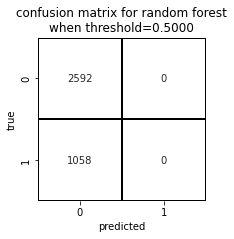



0.00% of the good stories have been correctly identified ~ recall
0.00% of the bad stories have been incorrectly identified as good ones ~ TNR




C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


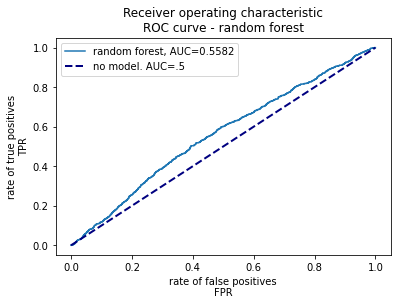

In [69]:
clf_rf = display_model_results(RandomForestClassifier(max_depth=5, n_jobs=-1), 
                      X_train_all, X_test_all, y_train, y_test, 
                      'random forest')

C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


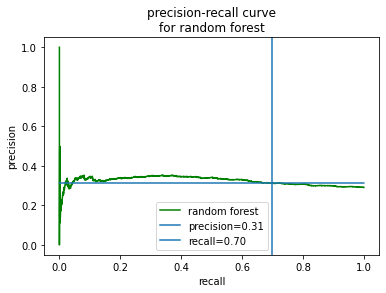



When recall is equal to 0.70, precision is equal to 0.31, and the threshold is equal to 0.28.
Classification report
for threshold=0.2836
              precision    recall  f1-score   support

           0       0.75      0.37      0.50      2592
           1       0.31      0.70      0.43      1058

    accuracy                           0.47      3650
   macro avg       0.53      0.54      0.47      3650
weighted avg       0.63      0.47      0.48      3650





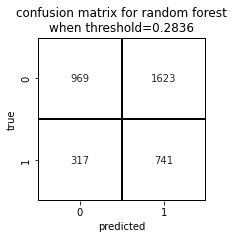



70.04% of the good stories have been correctly identified ~ recall
62.62% of the bad stories have been incorrectly identified as good ones ~ TNR


In [70]:
recall_value = 0.7 # chose wanted recall value
rf_probs = clf_rf.predict_proba(X_test_all)[:,1]
p_threshold = play_with_threshold(recall_value, y_test, rf_probs, 'random forest')

rf_pred = np.where(rf_probs >= p_threshold, 1, 0)
display_conf_matr(y_test, rf_pred, 'random forest', p_threshold)

### Adaboost

C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Classification report
for default threshold
              precision    recall  f1-score   support

           0       0.73      0.92      0.81      2592
           1       0.45      0.16      0.24      1058

    accuracy                           0.70      3650
   macro avg       0.59      0.54      0.52      3650
weighted avg       0.65      0.70      0.65      3650





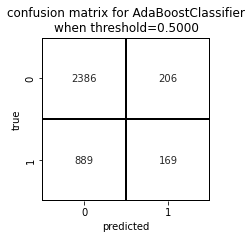



15.97% of the good stories have been correctly identified ~ recall
7.95% of the bad stories have been incorrectly identified as good ones ~ TNR




C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


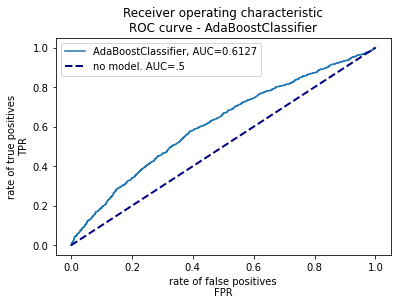

In [71]:
clf_ada = display_model_results(AdaBoostClassifier(n_estimators=100, random_state=0), 
                      X_train_all, X_test_all, y_train, y_test, 
                      'AdaBoostClassifier')

C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


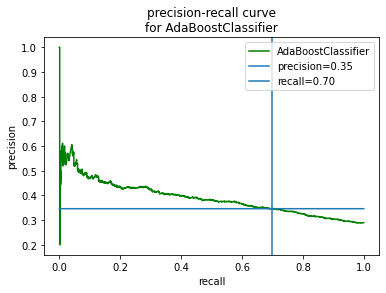



When recall is equal to 0.70, precision is equal to 0.35, and the threshold is equal to 0.50.
Classification report
for threshold=0.4969
              precision    recall  f1-score   support

           0       0.79      0.46      0.58      2592
           1       0.35      0.70      0.46      1058

    accuracy                           0.53      3650
   macro avg       0.57      0.58      0.52      3650
weighted avg       0.66      0.53      0.55      3650





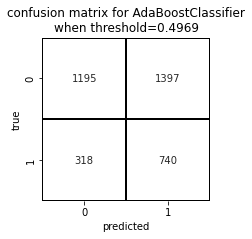



69.94% of the good stories have been correctly identified ~ recall
53.90% of the bad stories have been incorrectly identified as good ones ~ TNR


In [72]:
recall_value = 0.7 # chose wanted recall value
ada_probs = clf_ada.predict_proba(X_test_all)[:,1]
p_threshold = play_with_threshold(recall_value, y_test, ada_probs, 'AdaBoostClassifier')

ada_pred = np.where(ada_probs >= p_threshold, 1, 0)
display_conf_matr(y_test, ada_pred, 'AdaBoostClassifier', p_threshold)

### GradientBoostingClassifier

C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Classification report
for default threshold
              precision    recall  f1-score   support

           0       0.73      0.92      0.81      2592
           1       0.43      0.14      0.21      1058

    accuracy                           0.70      3650
   macro avg       0.58      0.53      0.51      3650
weighted avg       0.64      0.70      0.64      3650





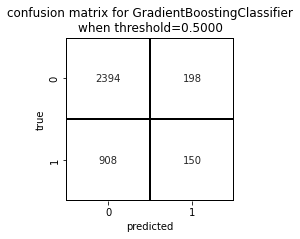



14.18% of the good stories have been correctly identified ~ recall
7.64% of the bad stories have been incorrectly identified as good ones ~ TNR




C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


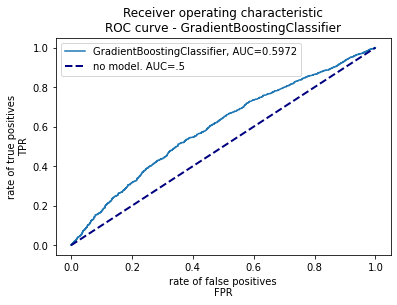

In [73]:
clf_gbc = display_model_results(GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0), 
                      X_train_all, X_test_all, y_train, y_test, 
                      'GradientBoostingClassifier')

C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


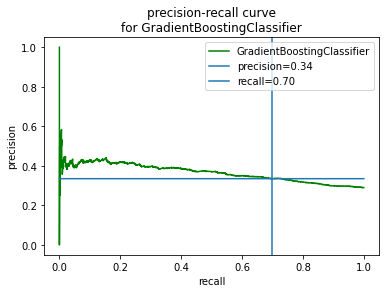



When recall is equal to 0.70, precision is equal to 0.34, and the threshold is equal to 0.22.
Classification report
for threshold=0.2184
              precision    recall  f1-score   support

           0       0.78      0.43      0.56      2592
           1       0.34      0.70      0.45      1058

    accuracy                           0.51      3650
   macro avg       0.56      0.57      0.51      3650
weighted avg       0.65      0.51      0.53      3650





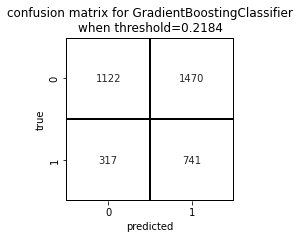



70.04% of the good stories have been correctly identified ~ recall
56.71% of the bad stories have been incorrectly identified as good ones ~ TNR


In [74]:
recall_value = 0.7 # chose wanted recall value
gbc_probs = clf_gbc.predict_proba(X_test_all)[:,1]
p_threshold = play_with_threshold(recall_value, y_test, gbc_probs, 'GradientBoostingClassifier')

gbc_pred = np.where(gbc_probs >= p_threshold, 1, 0)
display_conf_matr(y_test, gbc_pred, 'GradientBoostingClassifier', p_threshold)

### HistGradientBoostingClassifier

C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Classification report
for default threshold
              precision    recall  f1-score   support

           0       0.72      0.98      0.83      2592
           1       0.55      0.07      0.12      1058

    accuracy                           0.71      3650
   macro avg       0.64      0.52      0.47      3650
weighted avg       0.67      0.71      0.62      3650





C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


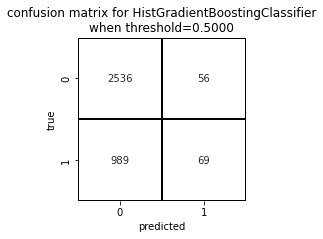



6.52% of the good stories have been correctly identified ~ recall
2.16% of the bad stories have been incorrectly identified as good ones ~ TNR




C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


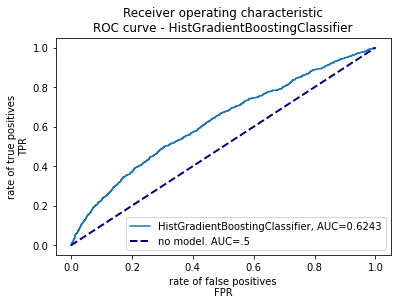

In [75]:
clf_hist = display_model_results(HistGradientBoostingClassifier(max_iter=100), 
                      X_train_all, X_test_all, y_train, y_test, 
                      'HistGradientBoostingClassifier')

C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


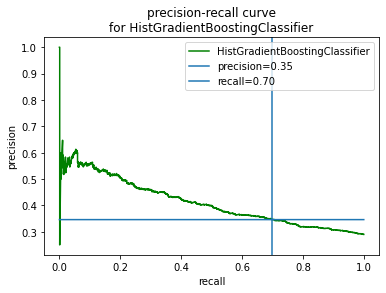



When recall is equal to 0.70, precision is equal to 0.35, and the threshold is equal to 0.25.
Classification report
for threshold=0.2466
              precision    recall  f1-score   support

           0       0.79      0.46      0.58      2592
           1       0.35      0.70      0.46      1058

    accuracy                           0.53      3650
   macro avg       0.57      0.58      0.52      3650
weighted avg       0.66      0.53      0.55      3650





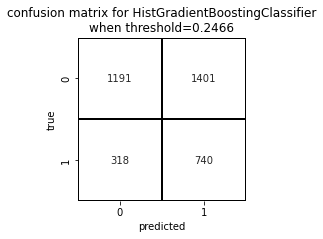



69.94% of the good stories have been correctly identified ~ recall
54.05% of the bad stories have been incorrectly identified as good ones ~ TNR


In [76]:
recall_value = 0.7 # chose wanted recall value
hist_probs = clf_hist.predict_proba(X_test_all)[:,1]
p_threshold = play_with_threshold(recall_value, y_test, hist_probs, 'HistGradientBoostingClassifier')

hist_pred = np.where(hist_probs >= p_threshold, 1, 0)
display_conf_matr(y_test, hist_pred, 'HistGradientBoostingClassifier', p_threshold)

### Soft vote

In [77]:
eclf = VotingClassifier(estimators=[('log', clf_log), 
                                    ('neigh', clf_neigh), 
                                    ('rf', clf_rf), 
                                    ('ada', clf_ada), 
                                    ('gbc', clf_gbc)], 
                        voting='soft')

C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Classification report
for default threshold
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      2592
           1       0.68      0.02      0.03      1058

    accuracy                           0.71      3650
   macro avg       0.70      0.51      0.43      3650
weighted avg       0.70      0.71      0.60      3650





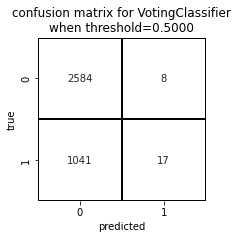



1.61% of the good stories have been correctly identified ~ recall
0.31% of the bad stories have been incorrectly identified as good ones ~ TNR




C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib

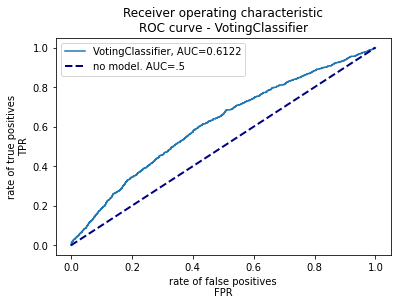

In [78]:
eclf = display_model_results(eclf, 
                      X_train_all, X_test_all, y_train, y_test, 
                      'VotingClassifier')

C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Batra\anaconda3\lib

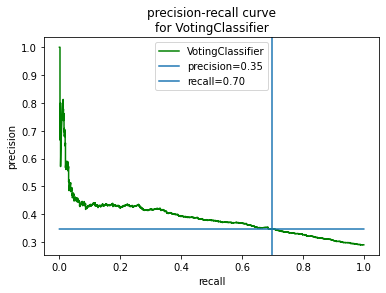



When recall is equal to 0.70, precision is equal to 0.35, and the threshold is equal to 0.31.
Classification report
for threshold=0.3103
              precision    recall  f1-score   support

           0       0.79      0.46      0.58      2592
           1       0.35      0.70      0.46      1058

    accuracy                           0.53      3650
   macro avg       0.57      0.58      0.52      3650
weighted avg       0.66      0.53      0.55      3650





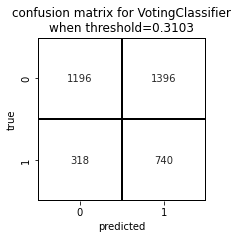



69.94% of the good stories have been correctly identified ~ recall
53.86% of the bad stories have been incorrectly identified as good ones ~ TNR


In [79]:
recall_value = 0.7 # chose wanted recall value
eclf_probs = eclf.predict_proba(X_test_all)[:,1]
p_threshold = play_with_threshold(recall_value, y_test, eclf_probs, 'VotingClassifier')

eclf_pred = np.where(eclf_probs >= p_threshold, 1, 0)
display_conf_matr(y_test, eclf_pred, 'VotingClassifier', p_threshold)

one graph of all our ROC curves

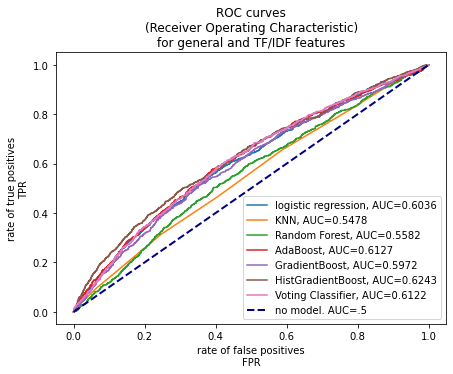

In [80]:
models = ['logistic regression', 'KNN', 'Random Forest', 'AdaBoost', 'GradientBoost', 'HistGradientBoost', 'Voting Classifier']
probs = [log_probs, knn_probs, rf_probs, ada_probs, gbc_probs, hist_probs, eclf_probs]

plt.figure(figsize=(7, 5))
for i, model in enumerate(models):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[i])
    auc = roc_auc_score(y_test, probs[i])

    plt.plot(fpr, tpr, label=f'{model}, AUC={auc:.4f}')
    
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="no model. AUC=.5")
plt.title('ROC curves\n(Receiver Operating Characteristic)\nfor general and TF/IDF features')
plt.xlabel('rate of false positives\nFPR')
plt.ylabel('rate of true positives\nTPR')
plt.legend(loc='best')
plt.show()

In [81]:
# def display_roc_curves(y_test,  y_probs, name_model, ax):
#     fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
#     auc = roc_auc_score(y_test, y_probs)

#     ax.plot(fpr, tpr, label=f'{name_model}, AUC={auc:.4f}')
#     ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="no model. AUC=.5")
#     ax.set(title=(f"Receiver operating characteristic\nROC curve - {name_model}"), 
#            xlabel=('rate of false positives\nFPR'), ylabel=('rate of true positives\nTPR'))

In [82]:
# f = plt.figure()

# display_roc_curves(y_test, log_probs, 'logistic regression', f.add_subplot(221))


# display_roc_curves(y_test, knn_probs, 'KNN', f.add_subplot(222))


# display_roc_curves(y_test, rf_probs, 'Random Forest', f.add_subplot(223))